## Demo with DECam data

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [14]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from detectron2.structures import BoxMode
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils

import weakref
import copy
import torch
import time
from typing import Dict, List, Optional

import imgaug.augmenters as iaa


from astropy.io import fits
import glob

from astrodet import astrodet as toolkit
from astrodet import detectron as detectron_addons

In [15]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.10.1
0.6


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style

set_mpl_style()

In [4]:
# Todo: change the dirpath here
dirpath = "/home/shared/hsc/decam/decam_data/"  # Path to dataset
output_dir = "/home/shared/hsc/decam/models/"

dataset_names = ["train", "test", "val"]

### Register Astro R-CNN dataset

For detectron2 to read the data, it must be in a dictionary format.  The function get_astro_dicts reads in the FITS files
and formats to a dictionary. 

However, this step can take a few minutes, and so we recommend only running it once and saving the dictionary data as a json file that can be 
read in at the beginning of your code


In [5]:
def get_astro_dicts(img_dir):

    # It's weird to call this img_dir
    set_dirs = sorted(glob.glob("%s/set_*" % img_dir))

    dataset_dicts = []

    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}

        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")

        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data / np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]

        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:, :][image > thresh[i]] = 1
            # Smooth mask
            mask[:, :] = cv2.GaussianBlur(mask[:, :], (9, 9), 2)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours(
                (mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            segmentation = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w * h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
for i, d in enumerate(dataset_names):
    filenames_dir = os.path.join(dirpath, d)
    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts(filenames_dir))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"], things_colors=["blue", "gray"])
astro_metadata = MetadataCatalog.get("astro_train")
dataset_dicts = {}

# for i, d in enumerate(dataset_names):
for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    dataset_dicts[d] = get_astro_dicts(os.path.join(dirpath, d))

In [8]:
# code snippet for unregistering if you want to change something

"""
if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")

"""

removing astro_train
removing astro_test
removing astro_val


Run the following 2 cells if your data is already saved in dictionary format. You will need to change file paths. If you already registered the data, you will need to run the cell above

In [5]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, "r") as f:
        data = json.load(f)
    return data


trainfile = os.path.join(dirpath, "train.json")
testfile = os.path.join(dirpath, "test.json")
valfile = os.path.join(dirpath, "val.json")

DatasetCatalog.register("astro_train", lambda: get_data_from_json(trainfile))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy"])
astrotrain_metadata = MetadataCatalog.get("astro_train")  # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy"])
astrotest_metadata = MetadataCatalog.get("astro_test")
# astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: get_data_from_json(valfile))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy"])
# astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist

namespace(name='astro_val', thing_classes=['star', 'galaxy'])

In [6]:
dataset_dicts = {}
# for i, d in enumerate(dataset_names):
for i, d in enumerate(dataset_names):
    print(f"Loading {d}")
    filenames_dir = os.path.join(dirpath, d)
    dataset_dicts[d] = get_data_from_json(filenames_dir + ".json")

Loading train
Loading test
Loading val


### Custom image reader

In [15]:
help(toolkit.read_image_decam)

Help on function read_image_decam in module astrodet.astrodet:

read_image_decam(filename, normalize='lupton', stretch=0.5, Q=10, m=0, ceil_percentile=99.995, dtype=<class 'numpy.uint8'>, A=10000.0, do_norm=False)



### Visualize ground truth examples

In [8]:
nsample = 3  # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(5 * nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    # Use the Lupton scaling for better visualization
    img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)

    visualizer = Visualizer(img, metadata=astrotrain_metadata)
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

Let's take a look at the pixel values as we change the constrast scaling

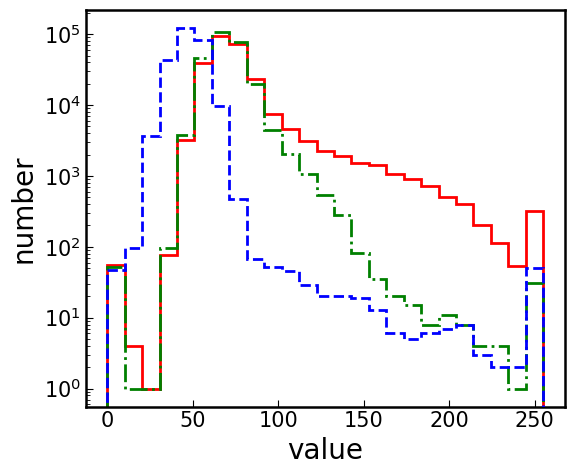

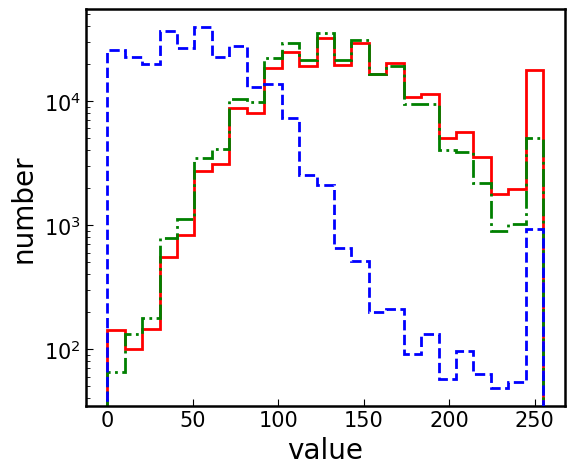

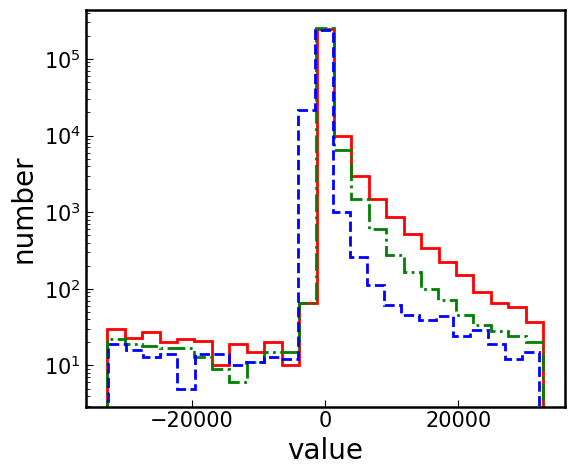

In [9]:
ns = 3
norms = ["astrolupton", "astroluptonhc", "zscore"]
for i, d in enumerate(random.sample(dataset_dicts["train"], ns)):
    norm = norms[i]
    dtype = np.uint8
    if norm == "zscore":
        dtype = np.int16
    # Use the Lupton scaling for better visualization
    # img = read_image(d["file_name"], normalize="zscore", stretch=5, Q=10, ceil_percentile=99.5)
    img = toolkit.read_image_decam(d["file_name"], normalize=norm, stretch=100, Q=10, dtype=dtype)
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    bins = 25
    # rng=(-3000,20000)
    ax.hist(
        img[:, :, 0].flatten(),
        histtype="step",
        bins=bins,
        log=True,
        color="r",
        lw=2,
        zorder=1,
    )
    ax.hist(
        img[:, :, 1].flatten(),
        histtype="step",
        bins=bins,
        log=True,
        color="g",
        lw=2,
        linestyle="-.",
        zorder=2,
    )
    ax.hist(
        img[:, :, 2].flatten(),
        histtype="step",
        bins=bins,
        log=True,
        color="b",
        lw=2,
        linestyle="dashed",
        zorder=3,
    )
    ax.set_xlabel("value", fontsize=20)
    ax.set_ylabel("number", fontsize=20)
    fig.tight_layout()

### Data Augmentations

We have customized the detectron2 code to allow for any data augmentation.  Some example functions are below

In [10]:
import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)


def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample() * 4 + 2))
    return aug.augment_image(image)


def addelementwise(image):
    aug = iaa.AddElementwise((-40, 40))
    return aug.augment_image(image)

The KRandomAugmentationList class will take a list of augmentations and and randomly apply k of them

In [45]:
def train_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = toolkit.read_image_decam(dataset_dict["file_name"], normalize="astrolupton", stretch=100, Q=10)

    augs = detectron_addons.KRandomAugmentationList(
        [
            # my custom augs
            T.RandomRotation([-90, 90, 180], sample_style="choice"),
            T.RandomFlip(prob=0.5),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            detectron_addons.CustomAug(gaussblur, prob=1.0),
            detectron_addons.CustomAug(addelementwise, prob=1.0),
        ],
        k=4,
    )

    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

Plot the original and augmented image

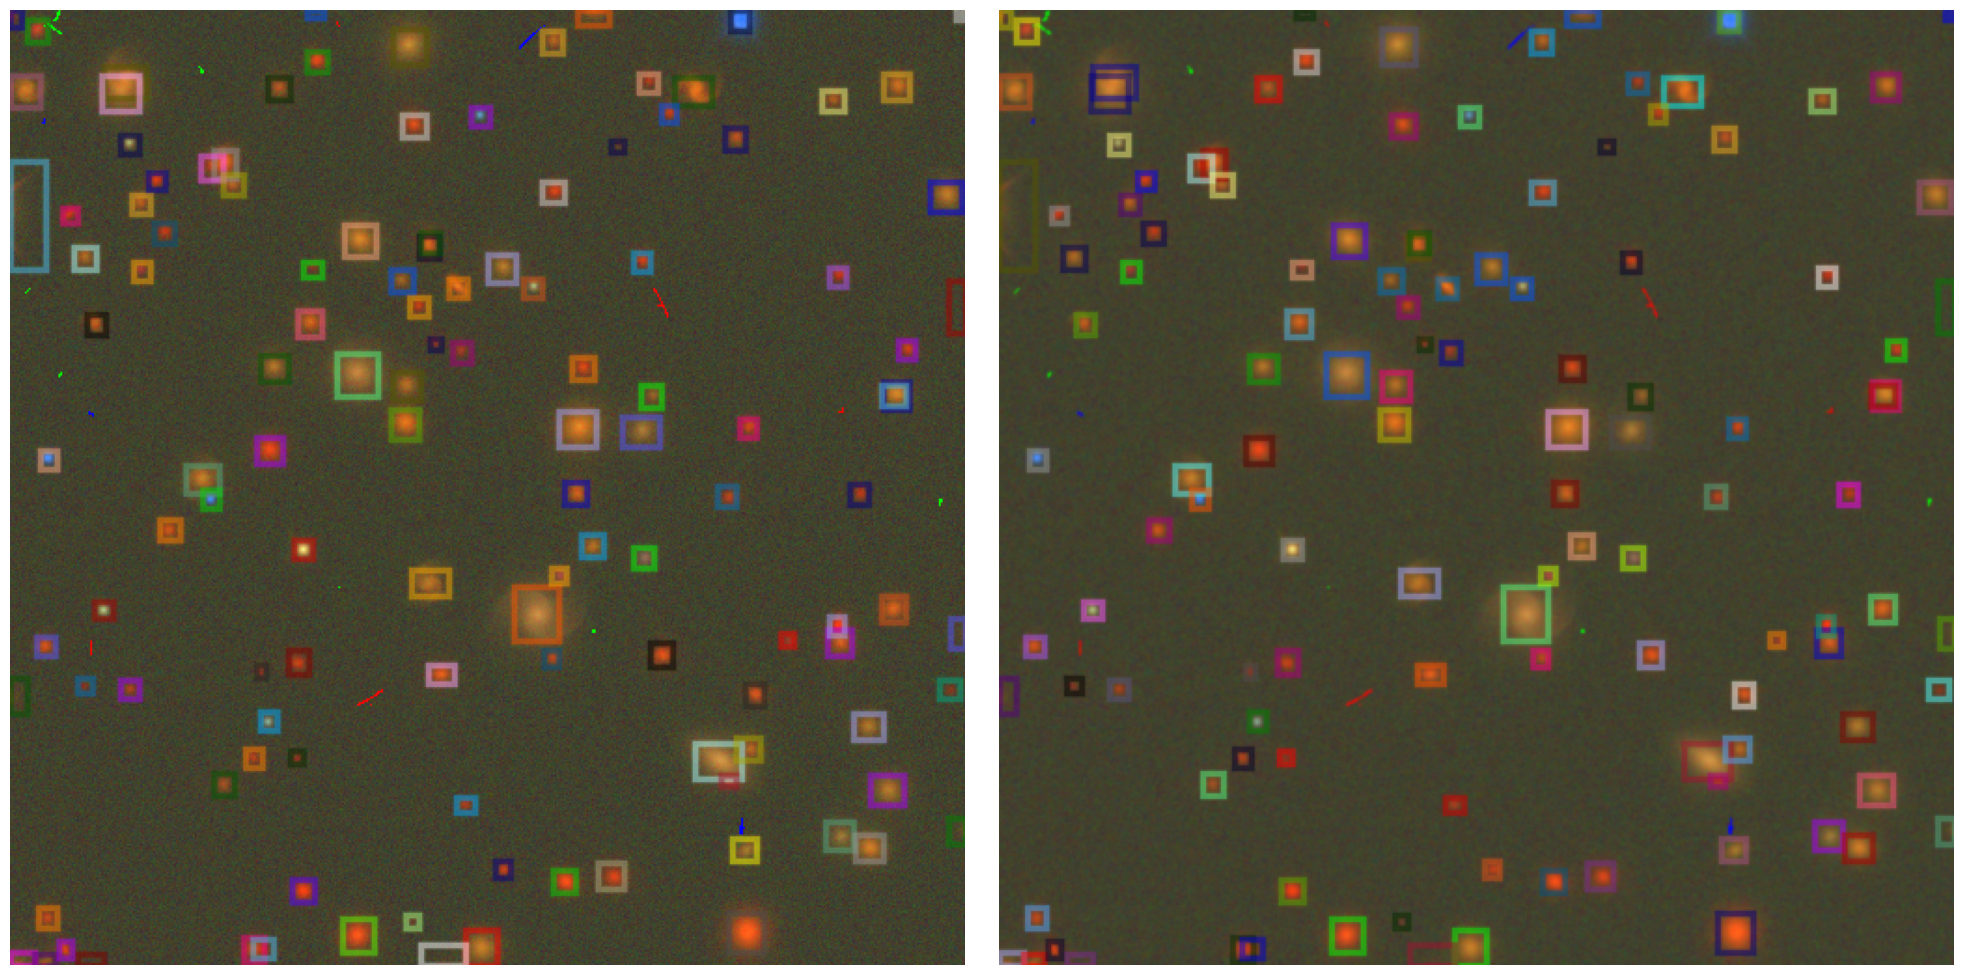

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10 * 2, 10))

d = random.sample(dataset_dicts["train"], 1)[0]


img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)
visualizer = Visualizer(img, metadata=astrotrain_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis("off")

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astrotrain_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d["instances"].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis("off")
fig.tight_layout()
fig.show()

### Prepare For Training

We prepare for training by intializing a config object and setting hyperparameters.  The we can take the intial weights from the pre-trained models in the model zoo.  For a full list of available config options, check https://detectron2.readthedocs.io/en/latest/modules/config.html

This setup is for demo purposes, so it does not follow the full training schedule we use for the paper.  You can check the train_decam.py script for the final training configurations 

In [48]:
init_coco_weights = True  # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")
)  # Get model structure
cfg.DATASETS.TRAIN = "astro_train"  # Register Metadata
cfg.DATASETS.TEST = "astro_val"  # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"
    )  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, "model_temp.pth")  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR -- start from 0.005
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100  # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# cfg.MODEL.BACKBONE.NUM_CLASSES = 4
cfg.MODEL.BACKBONE.FREEZE_AT = 1

cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = detectron_addons.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)
print(type(optimizer))

[06/15 15:50:53 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[06/15 15:50:53 d2.data.build]: Using training sampler TrainingSampler
[06/15 15:50:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 15:50:53 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[06/15 15:50:53 d2.data.common]: Serialized dataset takes 16.20 MiB
<class 'torch.optim.sgd.SGD'>


In [49]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 1
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: astro_val
  TRAIN: astro_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 1
    NAME: build_resnet_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: []
    NORM: 
    OUT_CHANNELS: 256
  K

In [50]:
# Hack if you get SSL certificate error
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [51]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
trainer.set_period(10)  # print loss every n iterations
trainer.train(0, 400)

[06/15 15:51:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x/137849525/model_final_4ce675.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[06/15 15:51:03 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  10  time:  3.7439167499542236e-07  loss:  tensor(2.2331, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  20  time:  3.259629011154175e-07  loss:  tensor(2.0845, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  30  time:  2.868473529815674e-07  loss:  tensor(1.7820, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  40  time:  3.129243850708008e-07  loss:  tensor(1.8019, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  50  time:  2.998858690261841e-07  loss:  tensor(1.6075, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  60  time:  3.594905138015747e-07  loss:  tensor(1.6220, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  70  time:  2.6635825634002686e-07  loss:  tensor(1.5565, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  80  time:  3.129243850708008e-07  loss:  tensor(1.4585, device='cuda:0', grad_fn=<AddBackward0>)
Iteration:  90  time:  3.241002559661865e-07  loss: 

### Plot The Loss

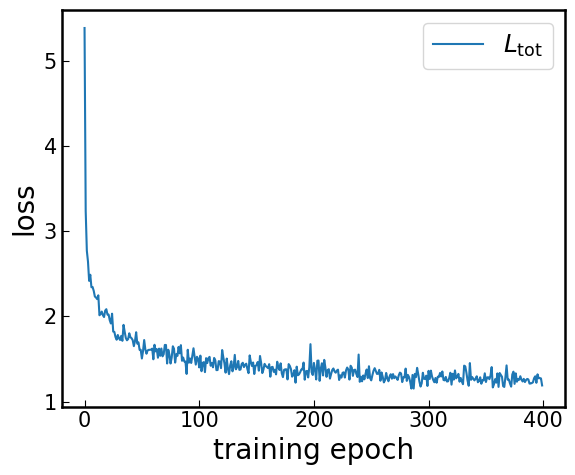

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
# ax.plot(losses, label=r'$L_{\rm{tot}}$')

ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
fig.tight_layout()

### Inference

Inference should use the config with parameters that are used in training
cfg now already contains everything we've set previously. We changed it a little bit for inference:

In [53]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/15 15:55:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/shared/hsc/decam/models/model_temp.pth ...


total instances: 153
detected instances: 155

total instances: 143
detected instances: 143

total instances: 164
detected instances: 168



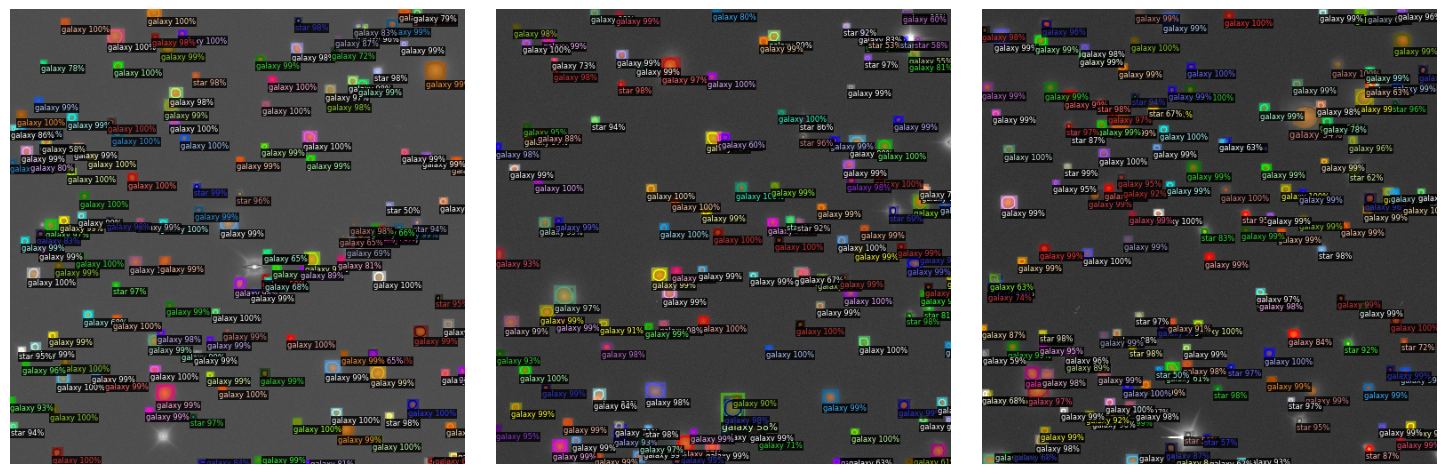

In [54]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5 * nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts["test"], nsample)):
    img = toolkit.read_image_decam(d["file_name"], normalize="astrolupton", stretch=100, Q=10)
    outputs = predictor(
        img
    )  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    print("total instances:", len(d["annotations"]))
    print("detected instances:", len(outputs["instances"].pred_boxes))
    print("")

    v = Visualizer(
        img,
        metadata=astrotest_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis("off")
    fig.tight_layout()
    fig.show()

### Evaluate

In [55]:
def test_mapper(dataset_dict):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = toolkit.read_image_decam(dataset_dict["file_name"], normalize="astrolupton", stretch=100, Q=10)
    augs = T.AugmentationList([])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
        # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos,
    }

In [56]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_val", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

test_loader = build_detection_test_loader(dataset_dicts["val"], mapper=test_mapper)

Loading  /home/shared/hsc/decam/models/astro_val_coco_format.json
[06/15 15:55:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/15 15:55:28 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[06/15 15:55:28 d2.data.common]: Serialized dataset takes 4.06 MiB


In [57]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[06/15 15:55:32 d2.evaluation.evaluator]: Start inference on 250 batches
[06/15 15:55:36 d2.evaluation.evaluator]: Inference done 11/250. Dataloading: 0.0748 s/iter. Inference: 0.1493 s/iter. Eval: 0.0717 s/iter. Total: 0.2957 s/iter. ETA=0:01:10
[06/15 15:55:41 d2.evaluation.evaluator]: Inference done 27/250. Dataloading: 0.0965 s/iter. Inference: 0.1495 s/iter. Eval: 0.0743 s/iter. Total: 0.3205 s/iter. ETA=0:01:11
[06/15 15:55:46 d2.evaluation.evaluator]: Inference done 43/250. Dataloading: 0.0943 s/iter. Inference: 0.1497 s/iter. Eval: 0.0743 s/iter. Total: 0.3184 s/iter. ETA=0:01:05
[06/15 15:55:51 d2.evaluation.evaluator]: Inference done 59/250. Dataloading: 0.0934 s/iter. Inference: 0.1499 s/iter. Eval: 0.0750 s/iter. Total: 0.3185 s/iter. ETA=0:01:00
[06/15 15:55:56 d2.evaluation.evaluator]: Inference done 75/250. Dataloading: 0.0929 s/iter. Inference: 0.1499 s/iter. Eval: 0.0751 s/iter. Total: 0.3181 s/iter. ETA=0:00:55
[06/15 15:56:02 d2.evaluation.evaluator]: Inference done 

In [44]:
results["bbox"]["AP-star"]

0.0

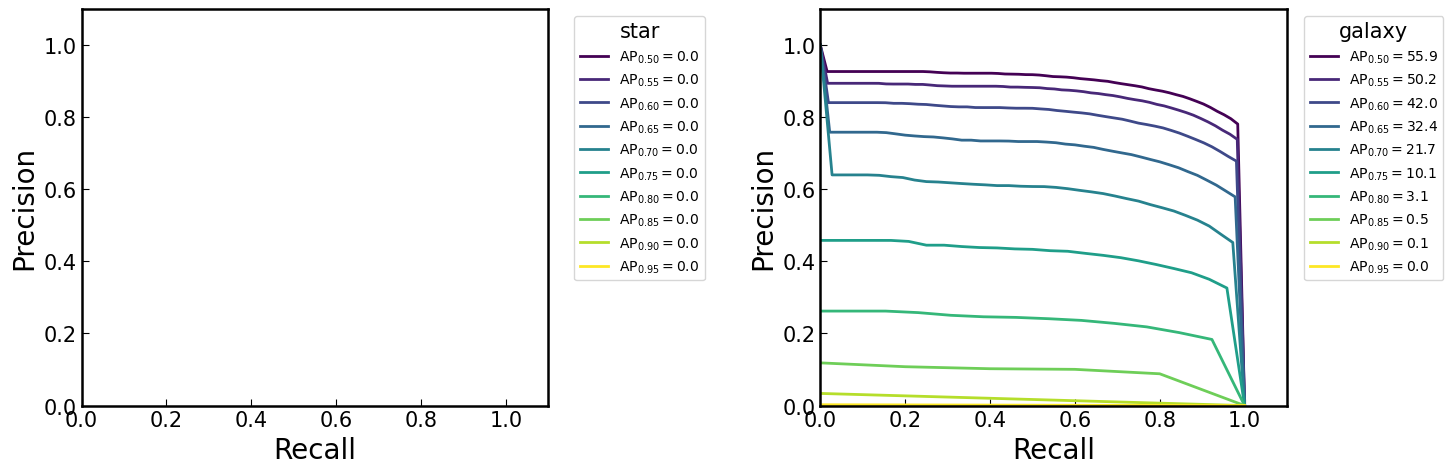

In [43]:
ap_type = "bbox"  # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ["star", "galaxy"]

results_per_category = results[ap_type]["results_per_category"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50, 0.95, 10)
colors = plt.cm.viridis(np.linspace(0, 1, len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = p_dat > 0
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p))  # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0]  # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100 * np.sum(p * dr)
        axs[j].plot(
            r, p, label=r"${\rm{AP}}_{%.2f} = %.1f$" % (iou, AP), color=colors[i], lw=2
        )  # use a viridis color scheme
        axs[j].set_xlabel("Recall", fontsize=20)
        axs[j].set_ylabel("Precision", fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f"{cls_names[j]}", bbox_to_anchor=(1.35, 1.0))

fig.tight_layout()